# What Makes a Great NBA Player?
## Introduction

With great competition comes with great comparison, especially in the realm of highly competitive modern sports league like the NBA. It thus become imperative to provide an accurate, standardized, and intuitive metric to compare different player's performance to distinguish, bad from good and good from great players. One such metric is the GameScore (GmSc) by John Holligner. 

##### GameScore (GmSc)
GameScore gives a rought measurement to quantify a player's productivity in a single game ([basketball reference](https://www.basketball-reference.com/about/glossary.html)). GmSc provides a weight for each definite statistics of a player's performance which can then be totaled out by adding all of them together, 40 is an outstanding performance, 10 is an average performance, etc. The weights/formula is as follows:  `Points` + 0.4 * `Field Goals Made` - 0.7 * `Field Goals Attempted` - 0.4*(`Free Throws Attempted` - `Free Throws Made`) + 0.7 * `Offensive Rebound` + 0.3 * `Defensive Rebound` + `Steals` + 0.7 * `Assists` + 0.7 * BLK - 0.4 * `Personal Fouls` - `Turnovers`.

But GameScore has its own limitation, as was every metric out there. A particularly glaring one is that it doesn't take into account that different players have different roles, depending on their position, and thus different emphasis on specific statistics that ultimately reflect their 'impact' and 'productivity'. It is also the case that different seasons/era has their own emphasis due to different factors like rules, officiating, star players, and just overall Most Effective Tactics Available (META).  

## Objectives
The objective of this Business Intelligence Report is twofold:
- To confirm the validity and accuracy of the GameScore formula based on historical data.
- To provide a new formula to take into account the position that a certain player plays (Guards, Forwards, and Centers).

## Principal Component Analysis (PCA)
PCA, in simple sense, simplify complex data by finding patterns and looking for correlation between different variables. By looking at their correlation, PCA will combine the correlated variables and put them in a single component (*principal component*). After that, PCA will rank the variables by how much variation (or 'importance') each component has. The more variant a component is, the more important it is because it helps us distinguish between high performing and low performing players. As opposed to lower variance, it may only mean noise so this doesn't help us much when distinguishing player's performances. These "importance" will serve as a weight for the final formula.

### PCA Assumptions
1. **PCA assumes a correlation between features**. If the features (or dimensions or columns, in tabular data) are not correlated, PCA will be unable to determine principal components.
2. **PCA is sensitive to the scale of the features**. Imagine we have two features - one takes values between 0 and 1000, while the other takes values between 0 and 1. PCA will be extremely biased towards the first feature being the first principle component, regardless of the actual maximum variance within the data. This is why it’s so important to standardize the values first.
3. **PCA is not robust against outliers**. Similar to the point above, the algorithm will be biased in datasets with strong outliers. This is why it is recommended to remove outliers before performing PCA.
4. **PCA assumes a linear relationship between features**. The algorithm is not well suited to capturing non-linear relationships. That’s why it’s advised to turn non-linear features or relationships between features into linear, using the standard methods such as log transforms.
5. **Technical implementations often assume no missing values**. When computing PCA using statistical software tools, they often assume that the feature set has no missing values (no empty rows). Be sure to remove those rows and/or columns with missing values, or impute missing values with a close approximation (e.g. the mean of the column).

Source: https://www.keboola.com/blog/pca-machine-learning

## Data Preparation
- Data Warehouse and step by step process to arrive at the df

Let us start by calculating the deviation of each nba player's stats from average stats by the same season.

<!-- # New Path (This renders the ALL-NBA chuchuness obselete, sadly)
## Deviation of each NBA players ('NBA players stats' - 'Average NBA Players') -->
Each NBA Player stats is in 'filetered_stats' df

Average NBA player stats by season is in 'average_stats_by_season_pos'

<!-- ### With Consideration to positions -->

#### Stats Per Game Original

In [115]:
import numpy as np
import pandas as pd

df_season_stats = df_season_awards = pd.read_csv('Player Per Game.csv')
df_season_stats.head()

,seas_id,season,player_id,player,birth_year,pos,age,experience,lg,tm,...,ft_percent,orb_per_game,drb_per_game,trb_per_game,ast_per_game,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game
0,31871,2025,5025,A.J. Green,NaN,SG,25.0,3,NBA,MIL,...,1.000,0.0,0.4,0.4,0.6,0.2,0.0,0.2,0.2,3.4
1,31872,2025,5210,AJ Johnson,NaN,SG,20.0,1,NBA,MIL,...,NaN,0.0,0.3,0.3,0.0,0.0,0.0,0.0,0.0,0.7
2,31873,2025,4219,Aaron Gordon,NaN,PF,29.0,11,NBA,DEN,...,0.857,3.3,4.3,7.5,3.5,1.0,0.5,2.0,2.0,15.5
3,31874,2025,4582,Aaron Holiday,NaN,PG,28.0,7,NBA,HOU,...,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,31875,2025,4805,Aaron Nesmith,NaN,SF,25.0,5,NBA,IND,...,0.846,0.8,3.8,4.6,1.0,0.8,0.4,0.8,4.8,8.6


In [116]:
print(df_season_awards.duplicated(subset=['season', 'player_id']).sum())
print(df_season_stats.duplicated(subset=['season', 'player_id']).sum())

6053
6053


### Combining Duplicated rows
as it turns out, players who were traded half-way have separate entry. Before we could proceed accordingly, it is imperative to combine them.

In [117]:
def weighted_mean(series, weights):
    return (series * weights).sum() / weights.sum()

aggregation_dict = {
    'mp_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),   # Weighted minutes
    'fg_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),   # Weighted field goals
    'fga_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted field goal attempts
    'fg_percent': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),    # Weighted FG%
    'x3p_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted 3-pointers made
    'x3pa_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']), # Weighted 3-point attempts
    'x3p_percent': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),   # Weighted 3P%
    'x2p_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted 2-pointers made
    'x2pa_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']), # Weighted 2-point attempts
    'x2p_percent': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),   # Weighted 2P%
    'e_fg_percent': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted Effective FG%
    'ft_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),   # Weighted free throws
    'fta_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted free throw attempts
    'ft_percent': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),    # Weighted FT%
    'orb_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted offensive rebounds
    'drb_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted defensive rebounds
    'trb_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted total rebounds
    'ast_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted assists
    'stl_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted steals
    'blk_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted blocks
    'tov_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted turnovers
    'pf_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),   # Weighted personal fouls
    'pts_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted points
}

additional_aggregation = {
    'seas_id': 'first',  # Keep the first season ID
    'player': 'first',   # Keep the player's name
    'birth_year': 'first',  # Keep birth year
    'pos': 'first',  # Keep the first position
    'age': 'mean',   # Average age
    'experience': 'mean',  # Average experience
    'g': 'sum'       # Total games played
}

aggregation_dict.update(additional_aggregation)

# df_combined = df_season_stats.groupby(['season', 'player_id']).agg(aggregation_dict).reset_index()
# df_combined.head()

### Loading Fixed NBA Stats Per Game without duplicates


In [118]:
nba_stats_per_game = pd.read_csv('nba_per_game_no_duplicates.csv')
nba_stats_per_game

,season,player_id,mp_per_game,fg_per_game,fga_per_game,fg_percent,x3p_per_game,x3pa_per_game,x3p_percent,x2p_per_game,...,tov_per_game,pf_per_game,pts_per_game,seas_id,player,birth_year,pos,age,experience,g
0,1947,1,0.0,3.8,15.0,0.256,0.0,0.0,0.000,3.8,...,0.0,2.0,9.8,1,Al Brightman,NaN,F,23.0,1.0,58
1,1947,2,0.0,0.2,1.6,0.125,0.0,0.0,0.000,0.2,...,0.0,1.2,0.8,2,Al Lujack,NaN,F,26.0,1.0,5
2,1947,3,0.0,1.2,6.3,0.188,0.0,0.0,0.000,1.2,...,0.0,1.8,2.8,3,Al Negratti,NaN,F-C,25.0,1.0,11
3,1947,4,0.0,3.8,13.6,0.281,0.0,0.0,0.000,3.8,...,0.0,2.0,9.4,4,Angelo Musi,NaN,G,28.0,1.0,60
4,1947,5,0.0,3.8,15.7,0.241,0.0,0.0,0.000,3.8,...,0.0,3.1,9.0,5,Ariel Maughan,1923.0,F,23.0,1.0,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26225,2025,5258,1.5,0.0,0.0,0.000,0.0,0.0,0.000,0.0,...,0.0,0.0,0.5,32274,Yongxi Cui,NaN,SG,21.0,1.0,2
26226,2025,5259,2.5,0.0,1.0,0.000,0.0,1.0,0.000,0.0,...,0.3,0.0,0.0,32275,Yuki Kawamura,NaN,PG,23.0,1.0,4
26227,2025,5260,19.8,2.6,5.6,0.464,0.0,0.0,0.000,2.6,...,0.8,1.6,6.8,32276,Yves Missi,NaN,C,20.0,1.0,5
26228,2025,5261,25.0,3.4,9.6,0.354,1.0,4.2,0.238,2.4,...,1.2,2.6,9.2,32277,Zaccharie Risacher,NaN,SF,19.0,1.0,5


### Defining Eligible Positions

In [119]:
df_season_info_players = pd.read_csv('Player Season Info.csv')
df_season_info_players.rename(columns={'pos': 'eligible_position'}, inplace=True)
df_season_info_players.head()
df_season_stats_new = nba_stats_per_game.merge(
    df_season_info_players[['season', 'player_id', 'eligible_position']], 
    how='left',
    on=['season', 'player_id']
)
df_season_stats_new[df_season_stats_new['season']>= 1979]['eligible_position'].unique()
df_season_stats_new['eligible_position'] = df_season_stats_new['eligible_position'].str.strip().str.upper()
df_season_stats_new_new = df_season_stats_new.assign(
    expanded_positions=df_season_stats_new['eligible_position'].str.split('-')
)

expanded_stats = df_season_stats_new_new.explode('expanded_positions')
expanded_stats = expanded_stats.rename(columns={'expanded_positions': 'primary_pos'})

def map_primary_pos(pos):
    if isinstance(pos, str):
        if 'G' in pos:
            return 'G'
        elif 'F' in pos:
            return 'F'
        elif 'C' in pos:
            return 'C'
    return None

expanded_stats['mapped_pos'] = expanded_stats['primary_pos'].apply(map_primary_pos)

filtered_stats = expanded_stats[expanded_stats['mapped_pos'].notna()]
filtered_stats = filtered_stats[filtered_stats['season'] >= 1979]

stats_list = list(aggregation_dict.items())
numeric_columns = [x[0] for x in stats_list if x[0] != 'player' and x[0] != 'pos']
filtered_stats_new = filtered_stats[numeric_columns + ['season', 'mapped_pos']]
filtered_stats_new.head(5)

,mp_per_game,fg_per_game,fga_per_game,fg_percent,x3p_per_game,x3pa_per_game,x3p_percent,x2p_per_game,x2pa_per_game,x2p_percent,...,tov_per_game,pf_per_game,pts_per_game,seas_id,birth_year,age,experience,g,season,mapped_pos
7646,23.9,2.1,4.9,0.423,0.0,0.0,0.0,2.1,4.9,0.423,...,1.2,2.2,5.6,7889,NaN,35.0,15.0,82,1979,F
7647,28.8,5.2,11.5,0.449,0.0,0.0,0.0,5.2,11.5,0.449,...,2.5,2.4,12.7,7755,NaN,35.0,14.0,74,1979,G
7648,32.1,5.8,12.5,0.461,0.0,0.0,0.0,5.8,12.5,0.461,...,2.5,2.4,13.5,7909,1944.0,34.0,13.0,80,1979,F
7649,9.6,1.4,3.3,0.433,0.0,0.0,0.0,1.4,3.3,0.433,...,0.6,0.9,3.7,7728,NaN,34.0,13.0,56,1979,G
7650,21.6,4.2,8.2,0.517,0.0,0.0,0.0,4.2,8.2,0.517,...,1.3,1.7,9.8,7848,NaN,34.0,13.0,78,1979,G


### Aggregate Stats By Season

In [120]:
average_stats_by_season = (
    filtered_stats_new.groupby(['season'])[numeric_columns]
    .mean()
    .reset_index()
)
average_stats_by_season = average_stats_by_season.drop(columns=['birth_year', 'experience', 'age', 'seas_id'])

average_stats_by_season.head()

,season,mp_per_game,fg_per_game,fga_per_game,fg_percent,x3p_per_game,x3pa_per_game,x3p_percent,x2p_per_game,x2pa_per_game,...,orb_per_game,drb_per_game,trb_per_game,ast_per_game,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game,g
0,1979,21.362573,3.900498,8.144559,0.462301,0.000000,0.000000,0.000000,3.900498,8.144559,...,1.311494,2.660796,3.965291,2.207453,0.802076,0.456061,1.769061,2.310799,9.660958,79.857971
1,1980,22.100287,3.896301,8.217412,0.460350,0.067792,0.244079,0.151646,3.826243,7.964669,...,1.355910,2.708766,4.066309,2.302186,0.827243,0.469419,1.729335,2.300378,9.748031,79.811111
2,1981,21.009095,3.593292,7.597312,0.454277,0.046122,0.195050,0.119114,3.544075,7.397482,...,1.230815,2.442840,3.671026,2.220930,0.788575,0.431810,1.614569,2.249191,9.036881,72.442308
3,1982,20.927232,3.670659,7.568759,0.471673,0.048369,0.199787,0.135940,3.618885,7.362178,...,1.239082,2.465505,3.700405,2.072785,0.724021,0.449031,1.508614,2.379060,9.168158,74.839142
4,1983,20.535671,3.560657,7.461992,0.462408,0.041400,0.188442,0.114595,3.516895,7.271608,...,1.282293,2.506999,3.791138,2.104225,0.739111,0.465773,1.607972,2.322450,8.892125,78.407125


### Aggregate Stats By Season and Positions

In [121]:
average_stats_by_season_pos = (
    filtered_stats_new.groupby(['season', 'mapped_pos'])[numeric_columns]
    .mean()
    .reset_index()
)
average_stats_by_season_pos = average_stats_by_season_pos.drop(columns=['birth_year', 'experience', 'age', 'seas_id'])

average_stats_by_season_pos.head()

,season,mapped_pos,mp_per_game,fg_per_game,fga_per_game,fg_percent,x3p_per_game,x3pa_per_game,x3p_percent,x2p_per_game,...,orb_per_game,drb_per_game,trb_per_game,ast_per_game,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game,g
0,1979,C,22.160610,3.794890,7.615368,0.477111,0.000000,0.000000,0.000000,3.794890,...,2.043494,4.445156,6.480370,1.675883,0.578939,0.993442,1.822025,2.770788,9.455703,87.089552
1,1979,F,21.061238,3.921360,8.022316,0.473698,0.000000,0.000000,0.000000,3.921360,...,1.571457,3.123665,4.690446,1.611459,0.705524,0.471547,1.686488,2.371412,9.745082,74.841727
2,1979,G,21.279241,3.930540,8.521881,0.443766,0.000000,0.000000,0.000000,3.930540,...,0.698697,1.337839,2.027832,3.059670,1.006183,0.181549,1.826105,2.028465,9.675771,81.388489
3,1980,C,23.317605,3.789275,7.569953,0.483515,0.000537,0.020997,0.042829,3.787785,...,2.054681,4.578006,6.637407,1.836599,0.640671,1.006769,1.744359,2.747662,9.478759,83.246154
4,1980,F,22.008321,3.982965,8.308488,0.465798,0.038750,0.159331,0.134787,3.943292,...,1.684808,3.186891,4.873173,1.755439,0.763774,0.502807,1.716703,2.487789,9.963840,78.724832


### Calculate Deviations By Season (Player minus Average)

In [122]:
merged_stats_season = pd.merge(
    filtered_stats,
    average_stats_by_season,
    on=['season'],
    suffixes=('', '_avg') 
)

columns_to_calculate = [col for col in average_stats_by_season.columns if col not in ['season']]

for col in columns_to_calculate:
    merged_stats_season[f'{col}_deviation'] = merged_stats_season[col] - merged_stats_season[f'{col}_avg']

columns_to_drop = [f'{col}_avg' for col in columns_to_calculate]
final_stats_deviation_by_season = merged_stats_season.drop(columns=columns_to_drop)

final_stats_deviation_by_season.head()

,season,player_id,mp_per_game,fg_per_game,fga_per_game,fg_percent,x3p_per_game,x3pa_per_game,x3p_percent,x2p_per_game,...,orb_per_game_deviation,drb_per_game_deviation,trb_per_game_deviation,ast_per_game_deviation,stl_per_game_deviation,blk_per_game_deviation,tov_per_game_deviation,pf_per_game_deviation,pts_per_game_deviation,g_deviation
0,1979,834,23.9,2.1,4.9,0.423,0.0,0.0,0.0,2.1,...,1.888506,1.239204,3.034709,-0.807453,-0.402076,-0.256061,-0.569061,-0.110799,-4.060958,2.142029
1,1979,848,28.8,5.2,11.5,0.449,0.0,0.0,0.0,5.2,...,-0.411494,-1.060796,-1.465291,2.592547,0.397924,-0.256061,0.730939,0.089201,3.039042,-5.857971
2,1979,856,32.1,5.8,12.5,0.461,0.0,0.0,0.0,5.8,...,-0.811494,0.339204,-0.465291,4.092547,0.397924,0.043939,0.730939,0.089201,3.839042,0.142029
3,1979,872,9.6,1.4,3.3,0.433,0.0,0.0,0.0,1.4,...,-1.011494,-2.060796,-3.065291,-1.107453,-0.502076,-0.356061,-1.169061,-1.410799,-5.960958,-23.857971
4,1979,887,21.6,4.2,8.2,0.517,0.0,0.0,0.0,4.2,...,-0.511494,-1.660796,-2.165291,-0.407453,-0.102076,-0.256061,-0.469061,-0.610799,0.139042,-1.857971


### Calculate Deviations By Season and Position (Player minus Average in Position)

In [123]:
merged_stats_pos = pd.merge(
    filtered_stats,
    average_stats_by_season_pos,
    on=['season', 'mapped_pos'],
    suffixes=('', '_avg') 
)

columns_to_calculate = [col for col in average_stats_by_season_pos.columns if col not in ['season', 'mapped_pos']]

for col in columns_to_calculate:
    merged_stats_pos[f'{col}_deviation'] = merged_stats_pos[col] - merged_stats_pos[f'{col}_avg']

columns_to_drop = [f'{col}_avg' for col in columns_to_calculate]
final_stats_deviation_by_pos = merged_stats_pos.drop(columns=columns_to_drop)
columns_to_calculate_pos = [col for col in average_stats_by_season_pos.columns if col not in ['season', 'mapped_pos', 'player_id']]

final_stats_deviation_by_pos.head()

,season,player_id,mp_per_game,fg_per_game,fga_per_game,fg_percent,x3p_per_game,x3pa_per_game,x3p_percent,x2p_per_game,...,orb_per_game_deviation,drb_per_game_deviation,trb_per_game_deviation,ast_per_game_deviation,stl_per_game_deviation,blk_per_game_deviation,tov_per_game_deviation,pf_per_game_deviation,pts_per_game_deviation,g_deviation
0,1979,834,23.9,2.1,4.9,0.423,0.0,0.0,0.0,2.1,...,1.628543,0.776335,2.309554,-0.211459,-0.305524,-0.271547,-0.486488,-0.171412,-4.145082,7.158273
1,1979,848,28.8,5.2,11.5,0.449,0.0,0.0,0.0,5.2,...,0.201303,0.262161,0.472168,1.740330,0.193817,0.018451,0.673895,0.371535,3.024229,-7.388489
2,1979,856,32.1,5.8,12.5,0.461,0.0,0.0,0.0,5.8,...,-1.071457,-0.123665,-1.190446,4.688541,0.494476,0.028453,0.813512,0.028588,3.754918,5.158273
3,1979,872,9.6,1.4,3.3,0.433,0.0,0.0,0.0,1.4,...,-0.398697,-0.737839,-1.127832,-1.959670,-0.706183,-0.081549,-1.226105,-1.128465,-5.975771,-25.388489
4,1979,887,21.6,4.2,8.2,0.517,0.0,0.0,0.0,4.2,...,0.101303,-0.337839,-0.227832,-1.259670,-0.306183,0.018451,-0.526105,-0.328465,0.124229,-3.388489


## PCA By Season

Since in game score, only the pts, fg, fga, fta, ft, orb, drb, stl, ast, blk, pf, tov are considered, let's filter out the data to only accomodate for this.

In [124]:
gmSc_columns = [
    'pts_per_game', 'fg_per_game', 'fga_per_game', 'fta_per_game', 'ft_per_game',
    'orb_per_game', 'drb_per_game', 'stl_per_game', 'ast_per_game', 
    'blk_per_game', 'pf_per_game', 'tov_per_game'
]

filtered_stats_gmsc = final_stats_deviation_by_season[gmSc_columns]

filtered_deviations_gmsc = final_stats_deviation_by_season[
    [f"{col}_deviation" for col in gmSc_columns]
]

filtered_deviations_gmsc.columns = filtered_deviations_gmsc.columns.str.replace('_deviation', '')

filtered_deviations_gmsc.head()

,pts_per_game,fg_per_game,fga_per_game,fta_per_game,ft_per_game,orb_per_game,drb_per_game,stl_per_game,ast_per_game,blk_per_game,pf_per_game,tov_per_game
0,-4.060958,-1.800498,-3.244559,-0.103581,-0.463798,1.888506,1.239204,-0.402076,-0.807453,-0.256061,-0.110799,-0.569061
1,3.039042,1.299502,3.355441,0.296419,0.536202,-0.411494,-1.060796,0.397924,2.592547,-0.256061,0.089201,0.730939
2,3.839042,1.899502,4.355441,-0.403581,0.136202,-0.811494,0.339204,0.397924,4.092547,0.043939,0.089201,0.730939
3,-5.960958,-2.500498,-4.844559,-1.603581,-1.063798,-1.011494,-2.060796,-0.502076,-1.107453,-0.356061,-1.410799,-1.169061
4,0.139042,0.299502,0.055441,-0.903581,-0.463798,-0.511494,-1.660796,-0.102076,-0.407453,-0.256061,-0.610799,-0.469061


### Assumption 1: PCA assumes a correlation between features
This holds in our dataset due to some columns being correlated. For example, pts per game and fg_per_game and fga_per_game are all highly correlated to each other. 

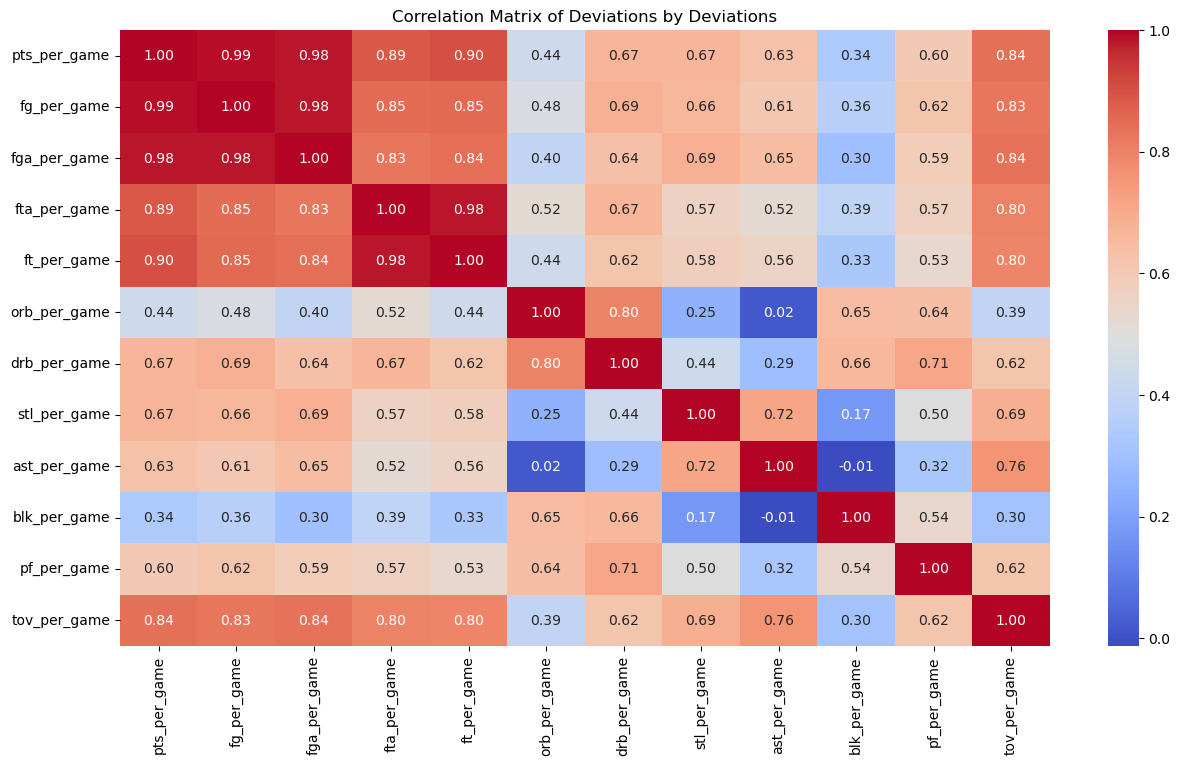

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns
columns_to_calculate = filtered_deviations_gmsc.columns.tolist()

correlation = filtered_deviations_gmsc[columns_to_calculate].corr()

plt.figure(figsize=(15, 8))
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Deviations by Deviations")
plt.show()

### Assumption 2: PCA is sensitive to the scale of the features
To achieve this assumption, we have to standardize the dataset. 
We have two choices: 

#### *Z-Score*
$$
z = \frac{x_{col} - \overline{x}_{col}}{s_{col}}
$$

Where: <br>
$x_{col}$ = original value of a row in 'col' column. <br>
$\overline{x}_{col}$ = mean of the 'col' column.<br>
$s_{col}$ = is the standard deviation of 'col' column.<br>
and $z$ is the z-score.

Upon getting the z-score, each cells will have a mean of 0 and a standard deviation of 1, which standardizes the data.

#### *X-Scaled*
$$
x_{scaled} = \frac{x_{col} - MEDIAN_{col}}{IQR_{col}}
$$

Where: <br>
$x_{col}$ = original value of a row in 'col' column. <br>
$MEDIAN_{col}$ = median of the 'col' column.<br>
$IQR_{col}$ = is the IQR of 'col' column (calculated by 75th Percentile minus 25th Percentile).<br>
and $x_{scaled}$ is the scaled value.

Upon getting the x-scaled, each cells will have a median of 0 and IQR of 1, which standardizes the data.

#### Difference
The difference is that X-Scaled method is more robust to outlier and skewed distribution rather than Z-Score method. If we use z-score, we have to remove the outliers becuase Z-score method exaggerates the effect of outliers, making the procedure of PAC unreliable. Removing outliers isn't ideal because we want to retain those high-performers because they are crucial for differentation between average players. **We shall proceed with X-Scaled** method to minimize the effect of outliers while retaining them.


In [126]:
medians = filtered_deviations_gmsc[columns_to_calculate].median()
iqrs = filtered_deviations_gmsc[columns_to_calculate].quantile(0.75) - filtered_deviations_gmsc[columns_to_calculate].quantile(0.25)

final_stats_standardized = filtered_deviations_gmsc[columns_to_calculate].apply(
    lambda x: (x - medians[x.name]) / iqrs[x.name], axis=0
)

final_stats_standardized = pd.concat(
    [filtered_deviations_gmsc.drop(columns=columns_to_calculate), final_stats_standardized],
    axis=1
)

print('Median per column (should be ~0)')
print(round(final_stats_standardized[columns_to_calculate].median()))

print('\nIQR per column (scaled, should be ~1)')
print(round(final_stats_standardized[columns_to_calculate].quantile(0.75) - final_stats_standardized[columns_to_calculate].quantile(0.25)))


Median per column (should be ~0)
pts_per_game    0.0
fg_per_game     0.0
fga_per_game    0.0
fta_per_game    0.0
ft_per_game     0.0
orb_per_game    0.0
drb_per_game    0.0
stl_per_game    0.0
ast_per_game    0.0
blk_per_game    0.0
pf_per_game     0.0
tov_per_game    0.0
dtype: float64

IQR per column (scaled, should be ~1)
pts_per_game    1.0
fg_per_game     1.0
fga_per_game    1.0
fta_per_game    1.0
ft_per_game     1.0
orb_per_game    1.0
drb_per_game    1.0
stl_per_game    1.0
ast_per_game    1.0
blk_per_game    1.0
pf_per_game     1.0
tov_per_game    1.0
dtype: float64


### Assumption 3: PCA is not robust against outliers
This is accounted for from the previous assumption's solution (the data has been X-Scaled). But just to check, here's the distribution for each column comparing the two methods (Z-Score and X-Scaled):


In [127]:
std_cols = filtered_deviations_gmsc[columns_to_calculate].std()
std_mean = filtered_deviations_gmsc[columns_to_calculate].mean()

final_stats_standardized_z = filtered_deviations_gmsc[columns_to_calculate].apply(
    lambda x: (x - std_mean[x.name]) / std_cols[x.name], axis=0
)

final_stats_standardized_z = pd.concat(
    [filtered_deviations_gmsc.drop(columns=columns_to_calculate), final_stats_standardized_z],
    axis=1
)

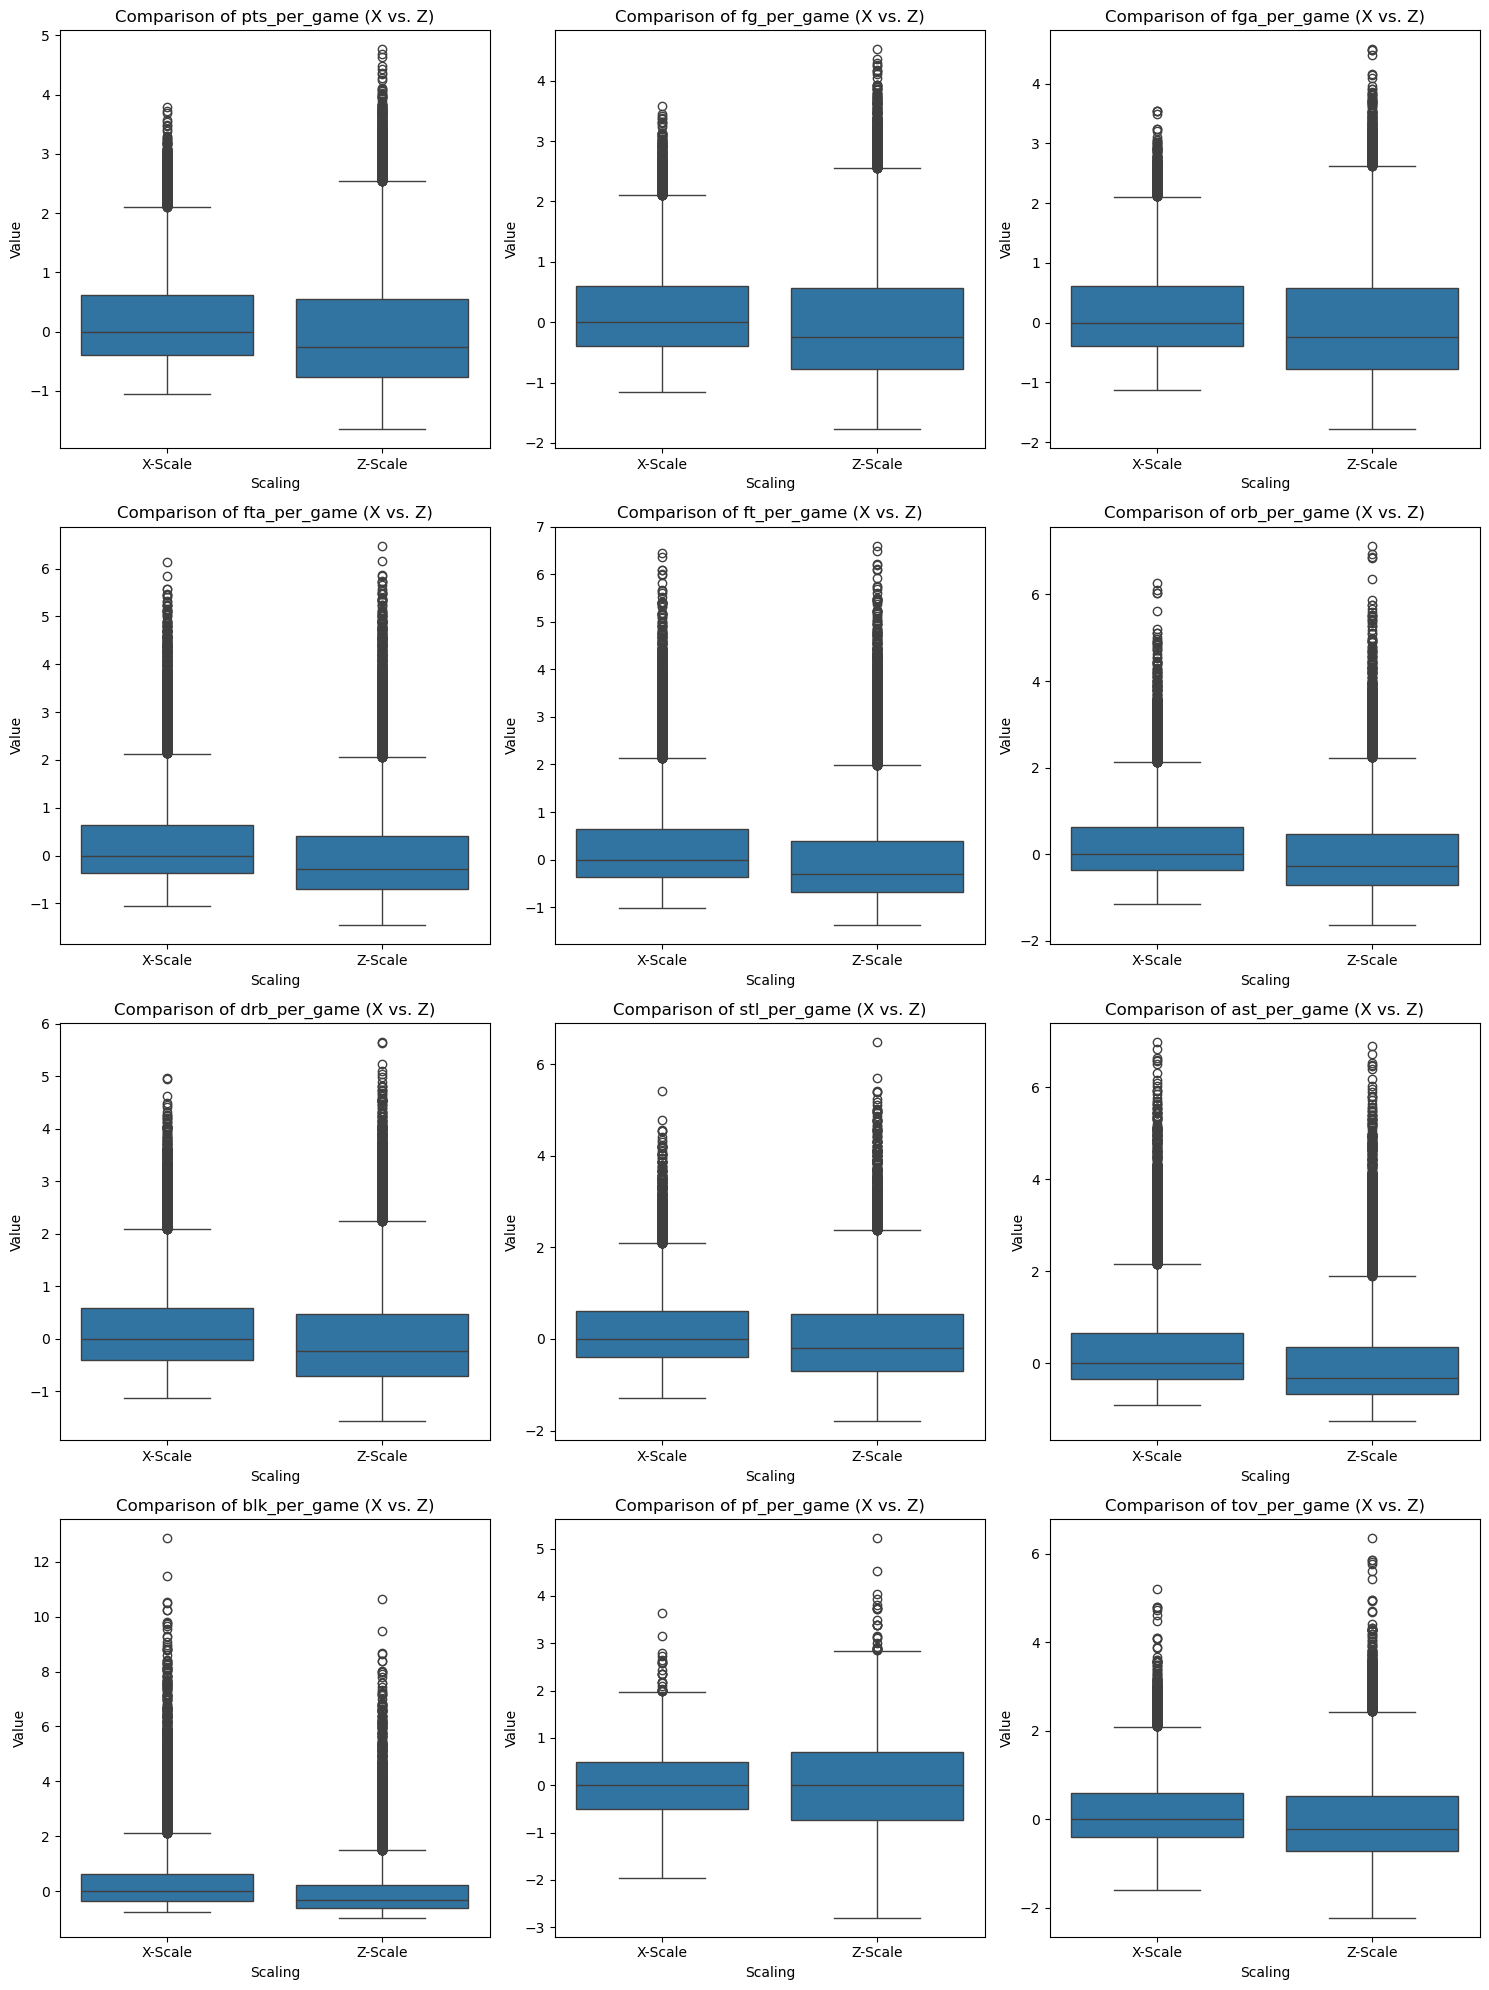

In [128]:
import math

num_columns = len(columns_to_calculate)

cols_per_row = 3
rows = math.ceil(num_columns / cols_per_row)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(15, 5 * rows)) 
axes = axes.flatten()

for i, col in enumerate(columns_to_calculate):
    comparison_data = pd.DataFrame({
        'Value': pd.concat([final_stats_standardized[col], final_stats_standardized_z[col]]),
        'Scaling': ['X-Scale'] * len(final_stats_standardized) + ['Z-Scale'] * len(final_stats_standardized_z),
    })
    
    sns.boxplot(x='Scaling', y='Value', data=comparison_data, ax=axes[i])
    axes[i].set_title(f"Comparison of {col} (X vs. Z)")

for j in range(num_columns, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('comp_x_z.png')

### Assumption 4: PCA assumes a linear relationship between features.
Since we are only trying to look for weights in a formula, we are essentailly computing for linear combination that determine a player's performance. So this still holds.

### Assumption 5: Technical implementations often assume no missing values.

In [129]:
na_count_per_column = final_stats_standardized[columns_to_calculate].isna().sum()

print(na_count_per_column)

pts_per_game    0
fg_per_game     0
fga_per_game    0
fta_per_game    0
ft_per_game     0
orb_per_game    0
drb_per_game    0
stl_per_game    0
ast_per_game    0
blk_per_game    0
pf_per_game     0
tov_per_game    0
dtype: int64


#### PCA TRAINING

In [130]:
from sklearn.decomposition import PCA

data_for_pca = final_stats_standardized[columns_to_calculate]
pca = PCA()

pca_results = pca.fit_transform(data_for_pca)

explained_variance_ratio = pca.explained_variance_ratio_

cumulative_variance = explained_variance_ratio.cumsum()

print("Explained Variance Ratio:", explained_variance_ratio)
print("Cumulative Explained Variance:", cumulative_variance)

Explained Variance Ratio: [6.13106548e-01 1.96518514e-01 6.04699215e-02 4.19647218e-02
 2.46825324e-02 2.18232909e-02 1.90996931e-02 1.12412732e-02
 8.74631044e-03 1.23005241e-03 9.25763685e-04 1.91378124e-04]
Cumulative Explained Variance: [0.61310655 0.80962506 0.87009498 0.91205971 0.93674224 0.95856553
 0.97766522 0.9889065  0.99765281 0.99888286 0.99980862 1.        ]


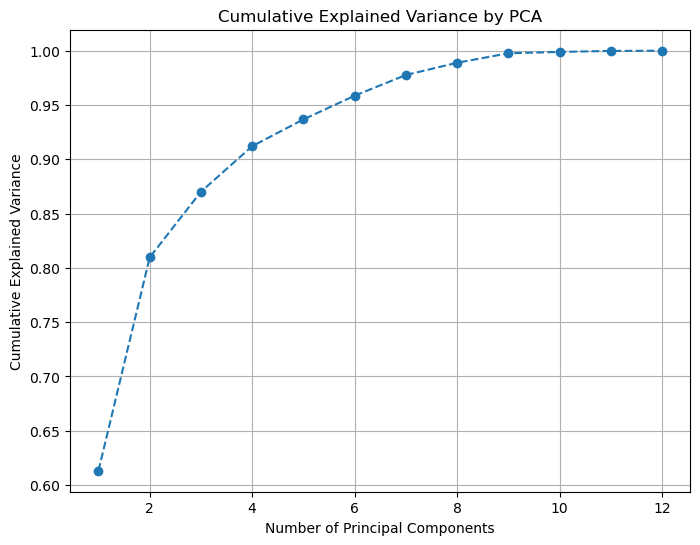

In [131]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA')
plt.grid()
plt.show()

In [132]:
n_components = sum(cumulative_variance < 0.95) + 1
print(f"Number of components to explain 95% variance: {n_components}")

Number of components to explain 95% variance: 6


In [133]:
# n_components = 12
pca_final = PCA(n_components=n_components)
pca_transformed_data = pca_final.fit_transform(data_for_pca)

pca_df = pd.DataFrame(
    pca_transformed_data,
    columns=[f"PC{i+1}" for i in range(n_components)]
)

print(pca_df.head())

        PC1       PC2       PC3       PC4       PC5       PC6
0 -0.662273  1.115542 -0.648268 -1.613975  1.075057  0.329140
1  0.954457 -1.772354  0.559194  0.149361  0.031528 -0.096120
2  1.372643 -1.622301  1.489764  0.535167  0.133207 -0.727989
3 -3.013231 -0.378154 -0.330340  0.558623  0.081982  0.076591
4 -1.118681 -0.638390 -0.221820  0.232807 -0.479115 -0.158861


In [134]:
loadings = pd.DataFrame(
    pca_final.components_,
    columns=columns_to_calculate,
    index=[f"PC{i+1}" for i in range(n_components)]
)

print("Feature Contributions to Principal Components:")
print(loadings)

Feature Contributions to Principal Components:
     pts_per_game  fg_per_game  fga_per_game  fta_per_game  ft_per_game  \
PC1      0.303481     0.300532      0.287382      0.356250     0.361353   
PC2     -0.112511    -0.088058     -0.132157     -0.054773    -0.115482   
PC3     -0.160485    -0.118666     -0.097737     -0.381109    -0.407570   
PC4      0.052467     0.002491      0.017380      0.171495     0.221974   
PC5     -0.260730    -0.315588     -0.344746      0.195696     0.147684   
PC6     -0.215694    -0.300265     -0.313747      0.324390     0.294870   

     orb_per_game  drb_per_game  stl_per_game  ast_per_game  blk_per_game  \
PC1      0.225004      0.293417      0.246583      0.261996      0.269402   
PC2      0.385718      0.255367     -0.213542     -0.439578      0.671159   
PC3     -0.093114      0.019394      0.430629      0.526707      0.358563   
PC4     -0.549379     -0.331779     -0.187035      0.093260      0.581883   
PC5      0.256855      0.171106     -0.470

In [135]:
explained_variance_ratio = pca_final.explained_variance_ratio_

weights = (loadings.T * explained_variance_ratio).sum(axis=1)

sorted_weights = weights.sort_values(ascending=False)

print("Sorted Feature Weights (Unnormalized):")
print(sorted_weights)

Sorted Feature Weights (Unnormalized):
blk_per_game    0.342034
drb_per_game    0.217453
fta_per_game    0.203716
orb_per_game    0.195738
ft_per_game     0.193603
tov_per_game    0.164558
pf_per_game     0.148791
fg_per_game     0.145540
pts_per_game    0.145310
stl_per_game    0.129844
fga_per_game    0.129688
ast_per_game    0.119416
dtype: float64


In [136]:
weights_normalized_pca = weights / weights.sum()

game_score_weights = {
    'pts_per_game': 1.0,
    'fg_per_game': 0.4,
    'fga_per_game': -0.7,
    'fta_per_game': -0.4,
    'ft_per_game': 0.4,
    'orb_per_game': 0.7,
    'drb_per_game': 0.3,
    'stl_per_game': 1.0,
    'ast_per_game': 0.7,
    'blk_per_game': 0.7,
    'pf_per_game': -0.4,
    'tov_per_game': -1.0
}

total_weight = sum(abs(w) for w in game_score_weights.values())
weights_normalized_gmsc = {k: abs(w) / total_weight for k, w in game_score_weights.items()}

weights_comparison_df = pd.DataFrame({
    'PCA_Normalized_Weights': weights_normalized_pca,
    'GmSc_Normalized_Weights': pd.Series(weights_normalized_gmsc)
})

weights_comparison_df = weights_comparison_df.fillna(0)

weights_comparison_df['difference'] = weights_comparison_df['GmSc_Normalized_Weights'] - weights_comparison_df['PCA_Normalized_Weights']

weights_comparison_df['PCA_Rank'] = weights_comparison_df['PCA_Normalized_Weights'].rank(ascending=False)
weights_comparison_df['GmSc_Rank'] = weights_comparison_df['GmSc_Normalized_Weights'].rank(ascending=False)
weights_comparison_df

,PCA_Normalized_Weights,GmSc_Normalized_Weights,difference,PCA_Rank,GmSc_Rank
pts_per_game,0.068039,0.129870,0.061831,9.0,2.0
fg_per_game,0.068146,0.051948,-0.016198,8.0,9.5
fga_per_game,0.060724,0.090909,0.030185,11.0,5.5
fta_per_game,0.095386,0.051948,-0.043438,3.0,9.5
ft_per_game,0.090651,0.051948,-0.038703,5.0,9.5
orb_per_game,0.091651,0.090909,-0.000742,4.0,5.5
drb_per_game,0.101819,0.038961,-0.062858,2.0,12.0
stl_per_game,0.060797,0.129870,0.069073,10.0,2.0
ast_per_game,0.055914,0.090909,0.034995,12.0,5.5
blk_per_game,0.160151,0.090909,-0.069242,1.0,5.5


<Figure size 1200x600 with 0 Axes>

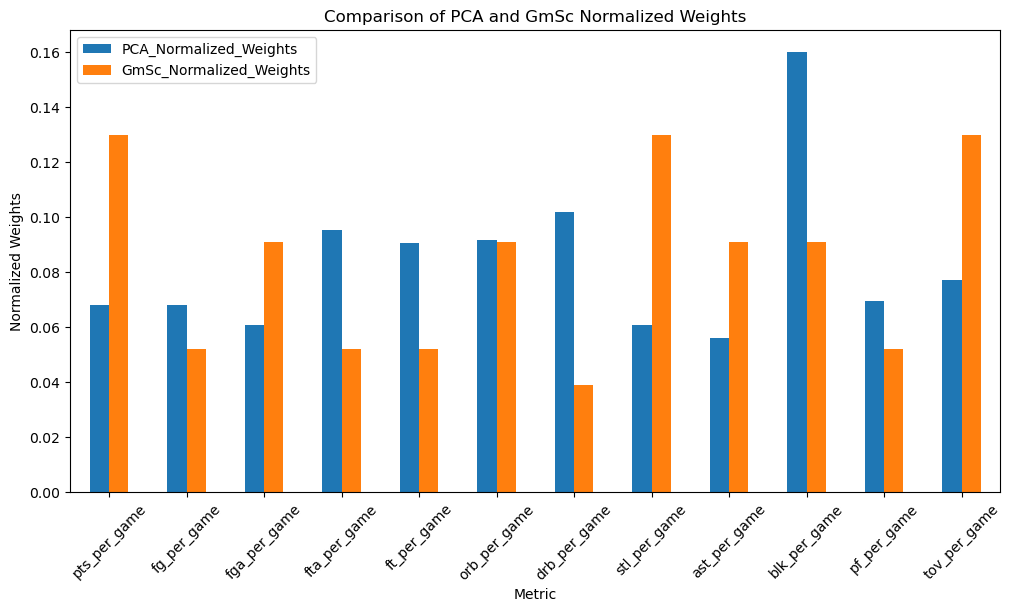

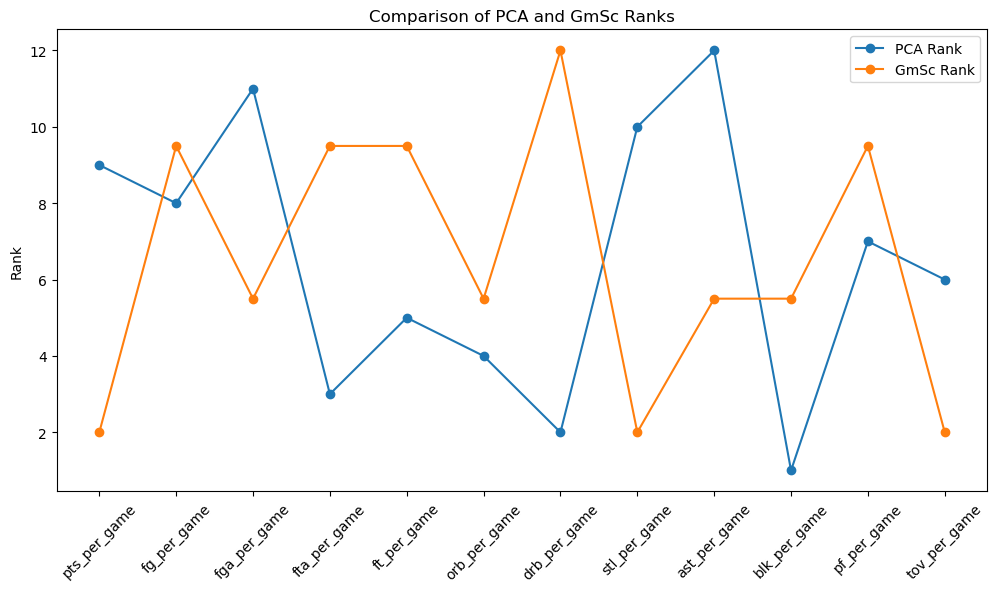

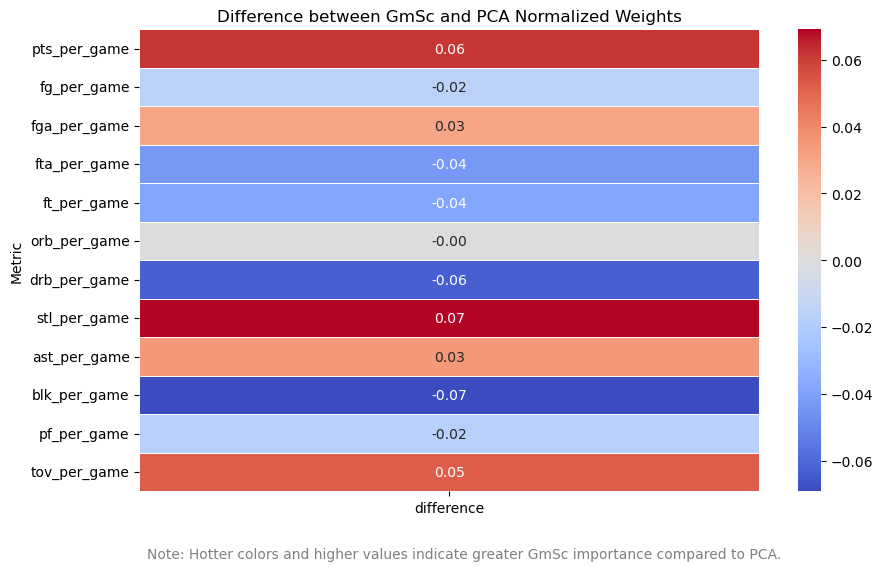

In [137]:
weights_comparison_df = weights_comparison_df.reset_index()

weights_comparison_df.rename(columns={'index': 'Metric'}, inplace=True)
plt.figure(figsize=(12, 6))
weights_comparison_df.plot(x='Metric', y=['PCA_Normalized_Weights', 'GmSc_Normalized_Weights'], kind='bar', figsize=(12, 6))
plt.title('Comparison of PCA and GmSc Normalized Weights')
plt.ylabel('Normalized Weights')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(weights_comparison_df['Metric'], weights_comparison_df['PCA_Rank'], marker='o', label='PCA Rank')
plt.plot(weights_comparison_df['Metric'], weights_comparison_df['GmSc_Rank'], marker='o', label='GmSc Rank')
plt.title('Comparison of PCA and GmSc Ranks')
plt.ylabel('Rank')
plt.xticks(rotation=45)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(weights_comparison_df[['difference']].set_index(weights_comparison_df['Metric']), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Difference between GmSc and PCA Normalized Weights')
plt.figtext(0.45, -0.001, "Note: Hotter colors and higher values indicate greater GmSc importance compared to PCA.",
            wrap=True, horizontalalignment='center', fontsize=10, color='gray')
plt.show()

## Observations

- **Comparison of `Points Per Game`**: While traditionally considered a key metric, the PCA-derived weight (`0.061831`, rank of 9) highlights its diminished importance in differentiating good and great players compared to the GmSc weight (`0.129870`, rank of 2). This suggests that the GmSc model prioritizes scoring more than the PCA model.

- **Emphasis on `Steals Per Game`**: PCA assigns it a relatively low weight (`0.060797`, rank 10), while GmSc assigns it the highest weight (`0.129870`, rank 2). This stark difference underscores how GmSc places a premium on defensive contributions, whereas PCA seems to downplay it.

- **Disparity in `Defensive Rebounds Per Game`**: PCA views this metric as one of the most important (`0.101819`, rank 2), in contrast to GmSc, where it holds much less significance (`0.038961`, rank 12). This indicates that PCA emphasizes defensive rebounding more than GmSc.

- **Similar Valuation of `Field Goals Made` and `Free Throws Made`**: Both metrics show minor differences in weights and rankings between the two models, reflecting general agreement on their lower importance for distinguishing greatness.

- **Key Takeaway**: The PCA-derived results reveal a focus on rebounding and a balanced metric evaluation, while the GmSc weights strongly emphasize defensive metrics like steals and offensive scoring efficiency. This contrast highlights the differing methodologies and priorities between PCA and GmSc models.



## Positions Specific Weights

In [138]:
filtered_deviations_pos = final_stats_deviation_by_pos[
    [f"{col}_deviation" for col in columns_to_calculate_pos]
]

filtered_deviations_pos.columns = filtered_deviations_pos.columns.str.replace('_deviation', '')

additional_columns = final_stats_deviation_by_pos[['season', 'mapped_pos']]

filtered_deviations_pos = pd.concat([additional_columns, filtered_deviations_pos], axis=1)

filtered_deviations_pos.head()

,season,mapped_pos,mp_per_game,fg_per_game,fga_per_game,fg_percent,x3p_per_game,x3pa_per_game,x3p_percent,x2p_per_game,...,orb_per_game,drb_per_game,trb_per_game,ast_per_game,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game,g
0,1979,F,2.838762,-1.82136,-3.122316,-0.050698,0.0,0.0,0.0,-1.82136,...,1.628543,0.776335,2.309554,-0.211459,-0.305524,-0.271547,-0.486488,-0.171412,-4.145082,7.158273
1,1979,G,7.520759,1.26946,2.978119,0.005234,0.0,0.0,0.0,1.26946,...,0.201303,0.262161,0.472168,1.740330,0.193817,0.018451,0.673895,0.371535,3.024229,-7.388489
2,1979,F,11.038762,1.87864,4.477684,-0.012698,0.0,0.0,0.0,1.87864,...,-1.071457,-0.123665,-1.190446,4.688541,0.494476,0.028453,0.813512,0.028588,3.754918,5.158273
3,1979,G,-11.679241,-2.53054,-5.221881,-0.010766,0.0,0.0,0.0,-2.53054,...,-0.398697,-0.737839,-1.127832,-1.959670,-0.706183,-0.081549,-1.226105,-1.128465,-5.975771,-25.388489
4,1979,G,0.320759,0.26946,-0.321881,0.073234,0.0,0.0,0.0,0.26946,...,0.101303,-0.337839,-0.227832,-1.259670,-0.306183,0.018451,-0.526105,-0.328465,0.124229,-3.388489


### Assumption 1: PCA assumes a correlation between features

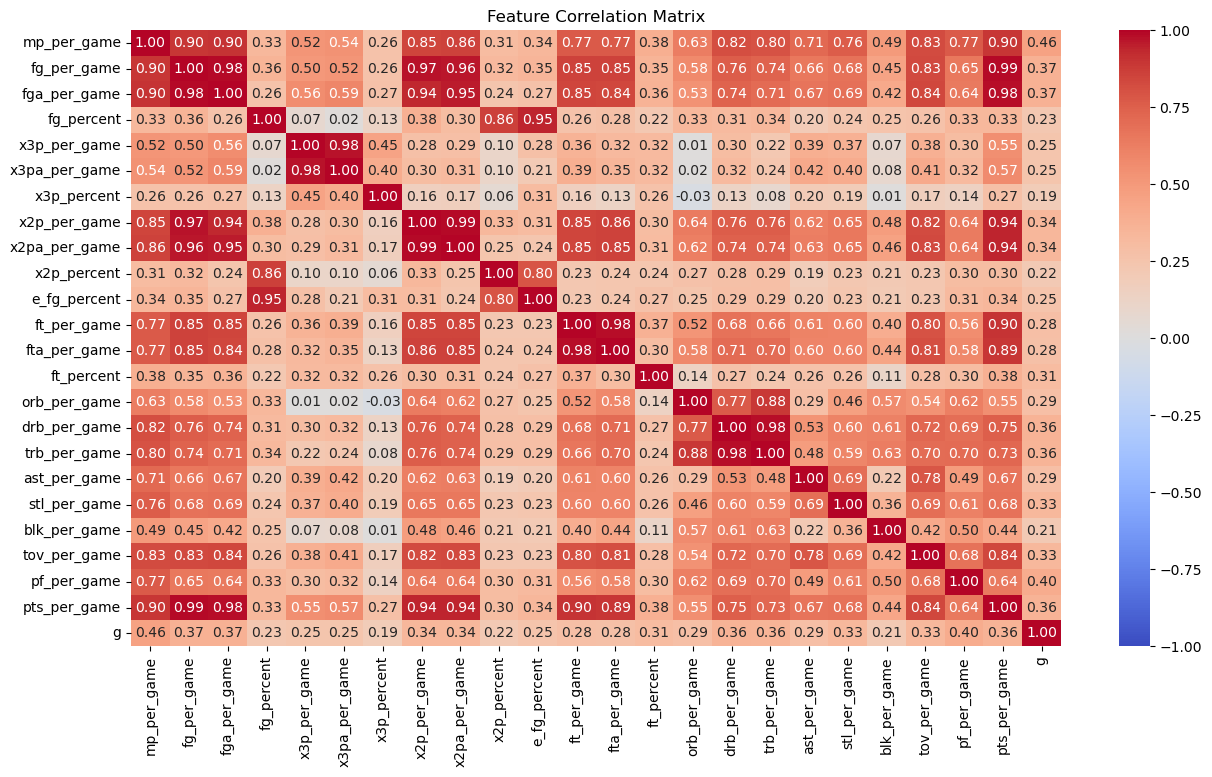

In [139]:
correlation_matrix = filtered_deviations_pos[columns_to_calculate_pos].corr()

plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title("Feature Correlation Matrix")
plt.show()

### Dropping Redundant Columns

In [140]:
correlated_features = set()
correlation_threshold = 0.9

for i in range(correlation_matrix.shape[0]):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

reduced_columns = [col for col in columns_to_calculate_pos if col not in correlated_features]

adjusted_columns_to_calculate = [col for col in columns_to_calculate_pos if col not in correlated_features]

print("Dropped Features Due to High Correlation:", correlated_features)
print("Adjusted Columns to Calculate PCA:", adjusted_columns_to_calculate)

Dropped Features Due to High Correlation: {'fta_per_game', 'x2pa_per_game', 'e_fg_percent', 'x2p_per_game', 'trb_per_game', 'fga_per_game', 'pts_per_game', 'x3pa_per_game'}
Adjusted Columns to Calculate PCA: ['mp_per_game', 'fg_per_game', 'fg_percent', 'x3p_per_game', 'x3p_percent', 'x2p_percent', 'ft_per_game', 'ft_percent', 'orb_per_game', 'drb_per_game', 'ast_per_game', 'stl_per_game', 'blk_per_game', 'tov_per_game', 'pf_per_game', 'g']


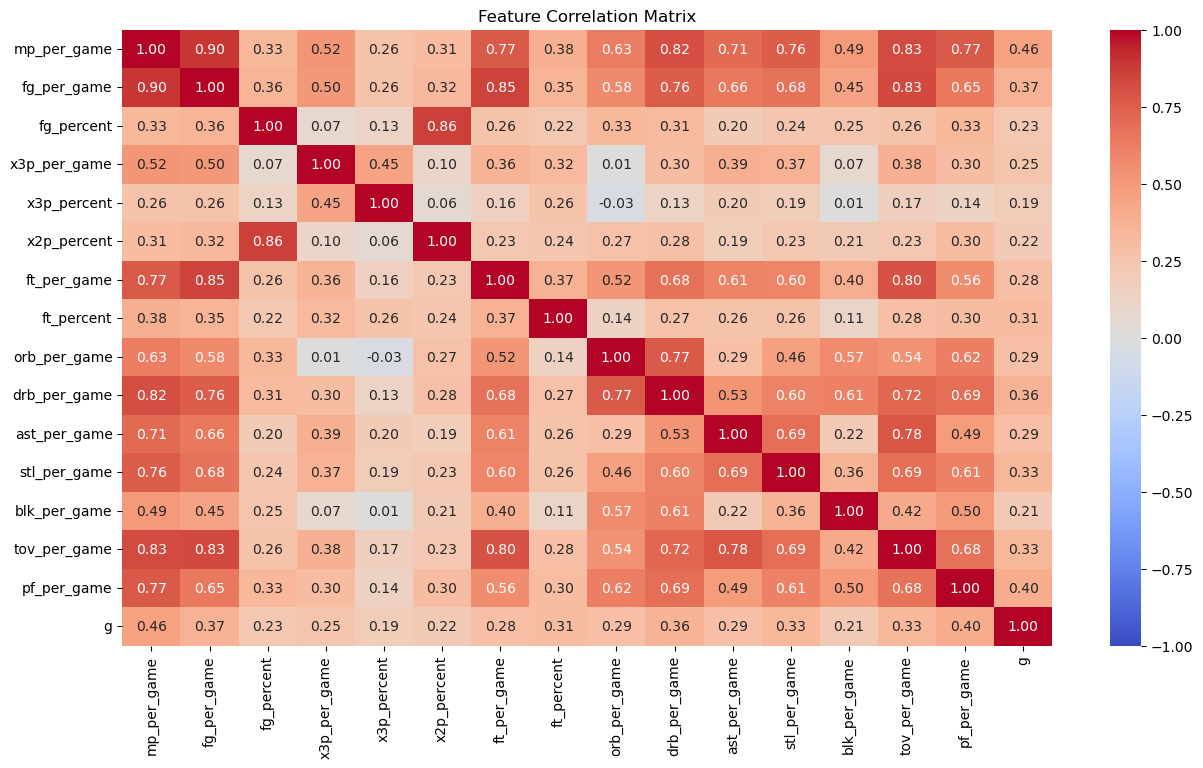

In [141]:
correlation_matrix = filtered_deviations_pos[adjusted_columns_to_calculate].corr()

plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title("Feature Correlation Matrix")
plt.show()

### Assumption 2: PCA is sensitive to the scale of the features

In [142]:
medians = filtered_deviations_pos[adjusted_columns_to_calculate].median()
iqrs = filtered_deviations_pos[adjusted_columns_to_calculate].quantile(0.75) - filtered_deviations_pos[adjusted_columns_to_calculate].quantile(0.25)

final_stats_standardized = filtered_deviations_pos[adjusted_columns_to_calculate].apply(
    lambda x: (x - medians[x.name]) / iqrs[x.name], axis=0
)

final_stats_standardized = pd.concat(
    [filtered_deviations_pos.drop(columns=adjusted_columns_to_calculate), final_stats_standardized],
    axis=1
)

print('Median per column (should be ~0)')
print(round(final_stats_standardized[adjusted_columns_to_calculate].median()))

print('\nIQR per column (scaled, should be ~1)')
print(round(final_stats_standardized[adjusted_columns_to_calculate].quantile(0.75) - final_stats_standardized[adjusted_columns_to_calculate].quantile(0.25)))

Median per column (should be ~0)
mp_per_game     0.0
fg_per_game     0.0
fg_percent      0.0
x3p_per_game    0.0
x3p_percent     0.0
x2p_percent     0.0
ft_per_game     0.0
ft_percent      0.0
orb_per_game    0.0
drb_per_game    0.0
ast_per_game    0.0
stl_per_game    0.0
blk_per_game    0.0
tov_per_game    0.0
pf_per_game     0.0
g               0.0
dtype: float64

IQR per column (scaled, should be ~1)
mp_per_game     1.0
fg_per_game     1.0
fg_percent      1.0
x3p_per_game    1.0
x3p_percent     1.0
x2p_percent     1.0
ft_per_game     1.0
ft_percent      1.0
orb_per_game    1.0
drb_per_game    1.0
ast_per_game    1.0
stl_per_game    1.0
blk_per_game    1.0
tov_per_game    1.0
pf_per_game     1.0
g               1.0
dtype: float64


### Assumption 3: PCA is not robust against outliers

### Assumption 4: PCA assumes a linear relationship between features.
Since we are only trying to look for weights in a formula, we are essentailly computing for linear combination that determine a player's performance. So this still holds.

### Assumption 5: Technical implementations often assume no missing values.

In [143]:
na_count_per_column = final_stats_standardized[adjusted_columns_to_calculate].isna().sum()
print(na_count_per_column)

mp_per_game     0
fg_per_game     0
fg_percent      0
x3p_per_game    0
x3p_percent     0
x2p_percent     0
ft_per_game     0
ft_percent      0
orb_per_game    0
drb_per_game    0
ast_per_game    0
stl_per_game    0
blk_per_game    0
tov_per_game    0
pf_per_game     0
g               0
dtype: int64


### PCA TRAINING

In [144]:
grouped_data = final_stats_standardized.groupby('mapped_pos')

for position, group_data in grouped_data:
    print(f"Running PCA for Position: {position}")
    
    data_for_pca = group_data[adjusted_columns_to_calculate]
    
    pca_temp = PCA()
    pca_temp.fit(data_for_pca)
    cumulative_variance = pca_temp.explained_variance_ratio_.cumsum()
    n_components = sum(cumulative_variance < 0.95) + 1
    
    print(f"Number of components to explain 95% variance for {position}: {n_components}")
    
    pca_final = PCA(n_components=n_components)
    pca_transformed_data = pca_final.fit_transform(data_for_pca)
    
    pca_df = pd.DataFrame(
        pca_transformed_data,
        columns=[f"PC{i+1}" for i in range(n_components)],
        index=group_data.index
    )
    
    print(f"PCA Results for Position: {position}")
    print(pca_df.head())
    print()


Running PCA for Position: C
Number of components to explain 95% variance for C: 8
PCA Results for Position: C
         PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
12  1.297375  1.783252 -1.357587 -2.278923  0.411117 -0.476419  0.547601   
19  9.289994 -2.367667  2.910441  2.122648  0.665403 -1.732529 -1.473434   
26  1.675074 -0.016161  1.339054  0.159962  0.594185 -0.270608 -0.208156   
27  3.305178 -0.335616 -1.062084 -0.874914  0.044770 -2.014763 -0.192172   
30 -1.475444  1.554371 -0.546441  0.628161 -0.109073 -0.189801 -0.442489   

         PC8  
12  0.742413  
19 -0.863487  
26  0.096095  
27 -0.814338  
30  0.400960  

Running PCA for Position: F
Number of components to explain 95% variance for F: 10
PCA Results for Position: F
         PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  -0.475511 -0.251592  1.130012 -0.059100 -0.698460  1.054132  0.730586   
2   1.239468 -1.470946 -1.013157  0.444593 -0.608512 -0.845691 -0.571088   
7  

In [145]:
from sklearn.decomposition import PCA

raw_weights_by_position = {}

for position, group_data in final_stats_standardized.groupby('mapped_pos'):
    print(f"Calculating raw weights for Position: {position}")
    
    data_for_pca = group_data[adjusted_columns_to_calculate]
    
    pca = PCA()
    pca.fit(data_for_pca)
    
    loadings = pd.DataFrame(
        pca.components_,
        columns=adjusted_columns_to_calculate,
        index=[f"PC{i+1}" for i in range(len(pca.components_))]
    )
    
    explained_variance_ratio = pca.explained_variance_ratio_
    
    raw_weights = (loadings.T * explained_variance_ratio).sum(axis=1)
    
    sorted_weights = raw_weights.sort_values(ascending=False)
    
    raw_weights_by_position[position] = sorted_weights
    
    print(f"Sorted Raw Feature Weights for {position}:")
    print(sorted_weights)
    print()


Calculating raw weights for Position: C
Sorted Raw Feature Weights for C:
blk_per_game    0.330816
fg_percent      0.239608
x2p_percent     0.238771
orb_per_game    0.132947
drb_per_game    0.122573
pf_per_game     0.089495
g               0.071237
mp_per_game     0.063544
fg_per_game     0.055369
x3p_percent     0.051814
stl_per_game    0.048537
tov_per_game    0.046742
ft_percent      0.044915
ft_per_game     0.035238
ast_per_game    0.020787
x3p_per_game   -0.005444
dtype: float64

Calculating raw weights for Position: F
Sorted Raw Feature Weights for F:
blk_per_game    0.220515
orb_per_game    0.215895
fg_percent      0.173885
drb_per_game    0.141793
x2p_percent     0.140699
pf_per_game     0.109498
g               0.101481
stl_per_game    0.077496
mp_per_game     0.070840
fg_per_game     0.066460
tov_per_game    0.063069
ft_percent      0.057952
ft_per_game     0.057669
ast_per_game    0.017715
x3p_percent    -0.023187
x3p_per_game   -0.065596
dtype: float64

Calculating raw weig

### Comparison to GmSc

In [146]:
from sklearn.decomposition import PCA
import pandas as pd

# Game Score normalized weights
game_score_weights = {
    'pts_per_game': 1.0,
    'fg_per_game': 0.4,
    'fga_per_game': -0.7,
    'fta_per_game': -0.4,
    'ft_per_game': 0.4,
    'orb_per_game': 0.7,
    'drb_per_game': 0.3,
    'stl_per_game': 1.0,
    'ast_per_game': 0.7,
    'blk_per_game': 0.7,
    'pf_per_game': -0.4,
    'tov_per_game': -1.0
}
total_weight = sum(abs(w) for w in game_score_weights.values())
weights_normalized_gmsc = {k: abs(w) / total_weight for k, w in game_score_weights.items()}

comparison_by_position = {}

for position, group_data in final_stats_standardized.groupby('mapped_pos'):
    print(f"Calculating PCA weights for Position: {position}")
    
    data_for_pca = group_data[adjusted_columns_to_calculate]

    pca = PCA() 
    pca.fit(data_for_pca)

    loadings = pd.DataFrame(
        pca.components_,
        columns=adjusted_columns_to_calculate,
        index=[f"PC{i+1}" for i in range(len(pca.components_))]
    )
    explained_variance_ratio = pca.explained_variance_ratio_

    pca_weights = (loadings.T * explained_variance_ratio).sum(axis=1)

    weights_normalized_pca = abs(pca_weights) / abs(pca_weights).sum()

    comparison_df = pd.DataFrame({
        'PCA_Normalized_Weights': weights_normalized_pca,
        'GmSc_Normalized_Weights': pd.Series(weights_normalized_gmsc)
    })

    comparison_df = comparison_df.fillna(0)

    comparison_df['difference'] = comparison_df['GmSc_Normalized_Weights'] - comparison_df['PCA_Normalized_Weights']

    comparison_df['PCA_Rank'] = comparison_df['PCA_Normalized_Weights'].rank(ascending=False)
    comparison_df['GmSc_Rank'] = comparison_df['GmSc_Normalized_Weights'].rank(ascending=False)

    comparison_by_position[position] = comparison_df

Calculating PCA weights for Position: C
Calculating PCA weights for Position: F
Calculating PCA weights for Position: G


In [147]:
comparison_by_position['C']

,PCA_Normalized_Weights,GmSc_Normalized_Weights,difference,PCA_Rank,GmSc_Rank
ast_per_game,0.013010,0.090909,0.077899,15.0,5.5
blk_per_game,0.207040,0.090909,-0.116131,1.0,5.5
drb_per_game,0.076712,0.038961,-0.037751,5.0,12.0
fg_per_game,0.034652,0.051948,0.017296,9.0,9.5
fg_percent,0.149958,0.000000,-0.149958,2.0,16.0
fga_per_game,0.000000,0.090909,0.090909,18.0,5.5
ft_per_game,0.022054,0.051948,0.029894,14.0,9.5
ft_percent,0.028110,0.000000,-0.028110,13.0,16.0
fta_per_game,0.000000,0.051948,0.051948,18.0,9.5
g,0.044583,0.000000,-0.044583,7.0,16.0


In [148]:
comparison_by_position['F']

,PCA_Normalized_Weights,GmSc_Normalized_Weights,difference,PCA_Rank,GmSc_Rank
ast_per_game,0.011046,0.090909,0.079863,16.0,5.5
blk_per_game,0.137500,0.090909,-0.046591,1.0,5.5
drb_per_game,0.088413,0.038961,-0.049452,4.0,12.0
fg_per_game,0.041440,0.051948,0.010508,10.0,9.5
fg_percent,0.108424,0.000000,-0.108424,3.0,16.0
fga_per_game,0.000000,0.090909,0.090909,18.0,5.5
ft_per_game,0.035959,0.051948,0.015989,14.0,9.5
ft_percent,0.036135,0.000000,-0.036135,13.0,16.0
fta_per_game,0.000000,0.051948,0.051948,18.0,9.5
g,0.063277,0.000000,-0.063277,7.0,16.0


In [149]:
comparison_by_position['G']

,PCA_Normalized_Weights,GmSc_Normalized_Weights,difference,PCA_Rank,GmSc_Rank
ast_per_game,0.091777,0.090909,-0.000868,5.0,5.5
blk_per_game,0.001196,0.090909,0.089713,16.0,5.5
drb_per_game,0.030381,0.038961,0.008580,13.0,12.0
fg_per_game,0.054621,0.051948,-0.002673,9.0,9.5
fg_percent,0.119447,0.000000,-0.119447,2.0,16.0
fga_per_game,0.000000,0.090909,0.090909,18.0,5.5
ft_per_game,0.057811,0.051948,-0.005863,8.0,9.5
ft_percent,0.127419,0.000000,-0.127419,1.0,16.0
fta_per_game,0.000000,0.051948,0.051948,18.0,9.5
g,0.081737,0.000000,-0.081737,6.0,16.0


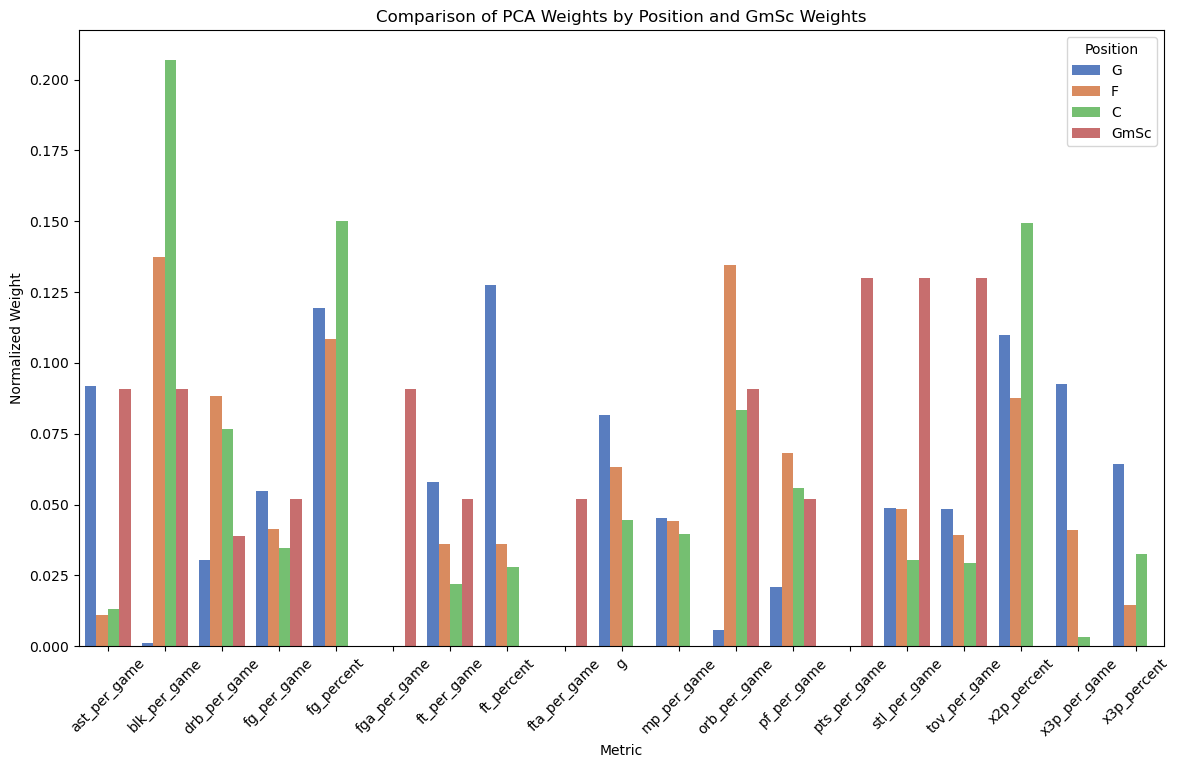

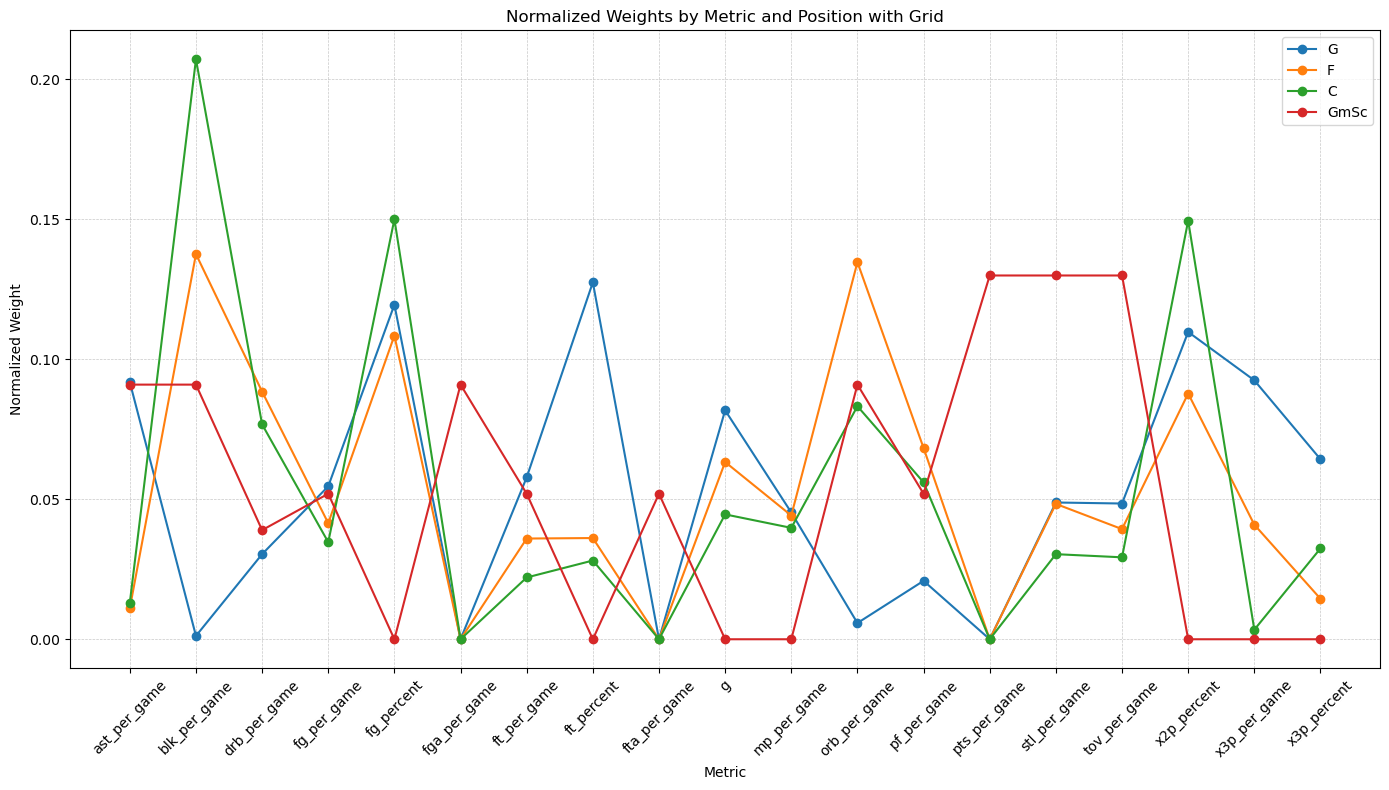

In [150]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

positions = ['G', 'F', 'C']

weights_data = []

for pos in positions:
    if pos in comparison_by_position:
        df = comparison_by_position[pos]
        weights_data.append(df['PCA_Normalized_Weights'].rename('Weights').reset_index().assign(Position=pos))

gm_sc_weights = comparison_by_position['G']['GmSc_Normalized_Weights'].rename('Weights').reset_index()
gm_sc_weights['Position'] = 'GmSc'
weights_data.append(gm_sc_weights)

weights_df = pd.concat(weights_data)

plt.figure(figsize=(14, 8))
sns.barplot(
    data=weights_df,
    x='index', y='Weights', hue='Position', dodge=True, palette='muted', errorbar=None
)
plt.title('Comparison of PCA Weights by Position and GmSc Weights')
plt.xlabel('Metric')
plt.ylabel('Normalized Weight')
plt.xticks(rotation=45)
plt.legend(title='Position')
plt.show()

plt.figure(figsize=(14, 8))


for pos in weights_df['Position'].unique():
    df = weights_df[weights_df['Position'] == pos]
    plt.plot(df['index'], df['Weights'], marker='o', label=f'{pos}')

plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.7) 

plt.title('Normalized Weights by Metric and Position with Grid')
plt.xlabel('Metric')
plt.ylabel('Normalized Weight')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


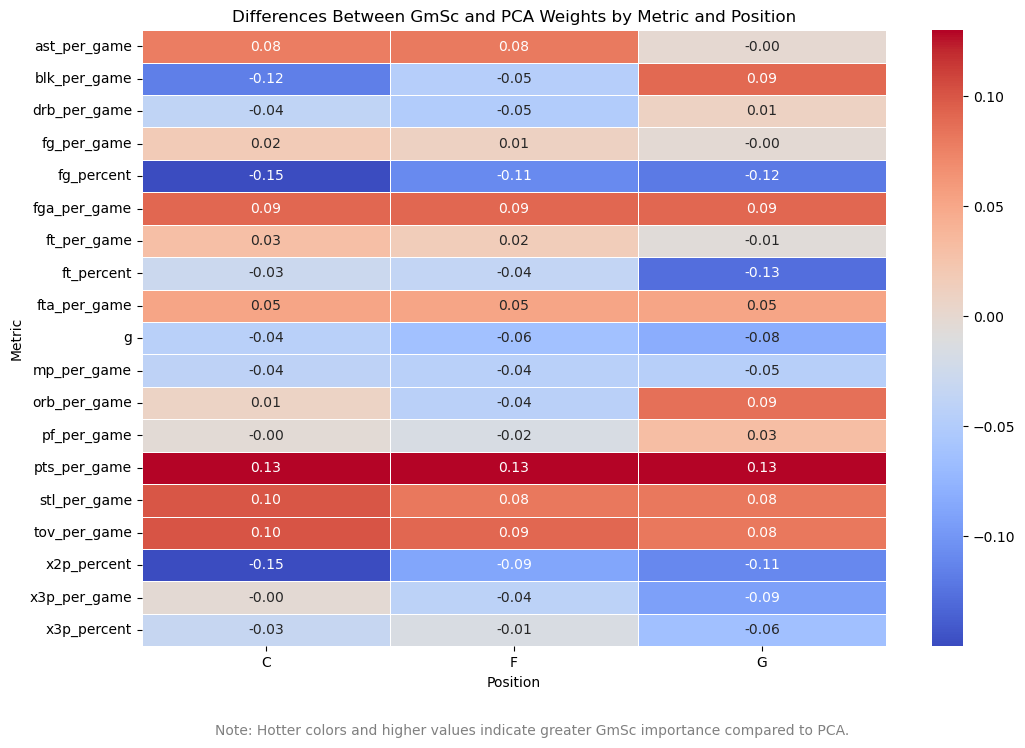

In [151]:
positions = ['G', 'F', 'C']

weights_data = []

for pos in positions:
    if pos in comparison_by_position:
        df = comparison_by_position[pos]
        df = df[['PCA_Normalized_Weights', 'GmSc_Normalized_Weights', 'difference', 'PCA_Rank', 'GmSc_Rank']].reset_index()
        df['Position'] = pos
        weights_data.append(df)

gm_sc_weights = comparison_by_position['G'][['GmSc_Normalized_Weights', 'GmSc_Rank']].rename(columns={'GmSc_Normalized_Weights': 'Weights'}).reset_index()
gm_sc_weights['Position'] = 'GmSc'
weights_data.append(gm_sc_weights)

weights_df = pd.concat(weights_data)
filtered_weights_df = weights_df[weights_df['Position'] != 'GmSc']

heatmap_data = filtered_weights_df.pivot(index='index', columns='Position', values='difference')
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Differences Between GmSc and PCA Weights by Metric and Position')
plt.ylabel('Metric')
plt.xlabel('Position')
plt.figtext(0.45, -0.001, "Note: Hotter colors and higher values indicate greater GmSc importance compared to PCA.",
            wrap=True, horizontalalignment='center', fontsize=10, color='gray')
plt.show()

In [152]:
weights_df

,index,PCA_Normalized_Weights,GmSc_Normalized_Weights,difference,PCA_Rank,GmSc_Rank,Position,Weights
0,ast_per_game,0.091777,0.090909,-0.000868,5.0,5.5,G,NaN
1,blk_per_game,0.001196,0.090909,0.089713,16.0,5.5,G,NaN
2,drb_per_game,0.030381,0.038961,0.008580,13.0,12.0,G,NaN
3,fg_per_game,0.054621,0.051948,-0.002673,9.0,9.5,G,NaN
4,fg_percent,0.119447,0.000000,-0.119447,2.0,16.0,G,NaN
...,...,...,...,...,...,...,...,...
14,stl_per_game,NaN,NaN,NaN,NaN,2.0,GmSc,0.12987
15,tov_per_game,NaN,NaN,NaN,NaN,2.0,GmSc,0.12987
16,x2p_percent,NaN,NaN,NaN,NaN,16.0,GmSc,0.00000
17,x3p_per_game,NaN,NaN,NaN,NaN,16.0,GmSc,0.00000


## Key Insights

#### Discrepancy Between PCA-Derived Weights and Game Score (GmSc) Weights:
- The PCA-derived weights differ significantly from the Game Score weights, suggesting that the GmSc formula does not fully reflect a player's "greatness" or "effectiveness" relative to their peers.
- While GmSc provides a general measure of productivity, it may overlook context-specific nuances, such as variations in player roles across positions or seasons.

#### Context-Specific Adjustments via Clustering:
- A more nuanced approach was employed by clustering the dataset by position and season. This accounts for the fact that different positions (e.g., guards, forwards, centers) have distinct responsibilities and contributions, which inherently influence their statistical importance.
- This methodology recognizes that metrics for "effectiveness" or "greatness" should be tailored to reflect the unique demands and expectations of each position.

#### Relative Performance Analysis:
- By calculating deviations from positional and seasonal averages, the PCA approach better captures a player's relative performance within their role. This ensures that comparisons are made on a level playing field, highlighting players who excel in their specific contexts rather than relying on a one-size-fits-all formula like GmSc.

#### Implications:
- The findings suggest that a refined evaluation metric, incorporating position- and season-specific weights derived from PCA, could provide a more accurate and equitable measure of player effectiveness.
- Traditional metrics like GmSc might undervalue players whose roles are not centered around high-scoring outputs but are crucial for team success (e.g., defensive specialists, playmakers).

In [153]:
all_nba_with_stats = pd.read_csv('nba_per_game_fixed.csv')

nba_2024 = all_nba_with_stats[
    (all_nba_with_stats['season'] == 2023) & 
    (all_nba_with_stats['type'] == 'All-NBA') & 
    (all_nba_with_stats['number_tm'].isin(['1T', '2T', '3T']))
]
nba_2024_with_scores = []

for position, group_data in nba_2024.groupby('position'):
    if position in comparison_by_position:
        position_weights = comparison_by_position[position]['PCA_Normalized_Weights']
        relevant_columns = position_weights.index.tolist()
        standardized_stats = group_data[relevant_columns].apply(lambda x: (x - x.mean()) / x.std())

        group_data['PCA_Score'] = standardized_stats.dot(position_weights)

        nba_2024_with_scores.append(group_data[['player_x', 'position', 'number_tm', 'PCA_Score']])

nba_2024_with_scores = pd.concat(nba_2024_with_scores)

nba_2024_with_scores = nba_2024_with_scores.sort_values(by='PCA_Score', ascending=False)

nba_2024_with_scores

,player_x,position,number_tm,PCA_Score
19,Giannis Antetokounmpo,F,1T,0.684431
23,Luka Dončić,G,1T,0.316198
24,Nikola Jokić,C,2T,0.202306
26,Stephen Curry,G,2T,0.142288
20,Jayson Tatum,F,1T,0.065314
29,Domantas Sabonis,C,3T,0.020807
22,Shai Gilgeous-Alexander,G,1T,-0.007755
31,Damian Lillard,G,3T,-0.019736
33,LeBron James,F,3T,-0.121048
25,Donovan Mitchell,G,2T,-0.133221
